In [33]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib as mpl

import neptune

from src.results.neptune import get_model_files, load_models, load_assemblies, load_params, load_properties,prep_assemblies,NeptuneExperimentRun

def set_style():
    # This sets reasonable defaults for font size for
    # a figure that will go in a paper
    sns.set_context("paper")
    
    # Set the font to be serif, rather than sans
#     sns.set(font='serif')
    
    # Make the background white, and specify the
    # specific font family
    sns.set_style("white", {
        "font.family": "sans-serif",
        "font.serif": ["Helvetica","serif"]
    })

## Load dicarlo single unit selectivities

In [71]:
import xarray
pix_da = xarray.open_dataarray(os.path.join(proj_root,'data','dicarlo_images','hi_pix.nc'))
pix_da = pix_da.rename(ty='tx',tz='ty')
pix_da = pix_da.set_index({
    'neuroid':['neuroid_id','region','subregion','layer'],
    'presentation':['image_id','object_name','category_name','tx','ty','rxy']
                 })

In [79]:
next(runs[0].load_assemblies(['dicarlo.DPX-64.nc'])).sel(layer=0)

<xarray.DataArray 'dicarlo' (presentation: 5760, neuroid: 12544)>
array([[-1., -1., -1., ..., -1., -1., -1.],
       [-1., -1., -1., ..., -1., -1., -1.],
       [-1., -1., -1., ..., -1., -1., -1.],
       ...,
       [-1., -1., -1., ..., -1., -1., -1.],
       [-1., -1., -1., ..., -1., -1., -1.],
       [-1., -1., -1., ..., -1., -1., -1.]], dtype=float32)
Coordinates:
    variation      (presentation) int32 ...
  * presentation   (presentation) MultiIndex
  - image_id       (presentation) object '8a72e2bfdb8c267b57232bf96f069374d5b21832' ... 'a533e519b553cdf360ae134f7c9f161134ddaf00'
  - dx             (presentation) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
  - dy             (presentation) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
  - rxy            (presentation) float64 -0.0 -0.0 -0.0 -0.0 ... -0.0 -0.0 -0.0
  - category_name  (presentation) object 'Cars' 'Tables' ... 'Fruits' 'Faces'
  - object_name    (presentation) object 'car_astra' 'table3' ... 'face0'
  - tx             (

In [2]:
proj_root = '/home/elijahc/projects/vae'

In [3]:
fp = os.path.join(proj_root,'data','su_selectivity_dicarlo_hi_var.pqt')
hda = pd.read_parquet(fp).dropna()[['neuroid_id','layer','region','tx','ty','rxy','category_name']]

hda = pd.melt(hda,id_vars=['neuroid_id','layer','region'],value_vars=['tx','ty','rxy','category_name'],var_name='attribute',value_name='selectivity')
hda['stimulus']='dicarlo'
hda['model']='macaque'

hda.head()

,neuroid_id,layer,region,attribute,selectivity,stimulus,model
0,pixel_10063,0,pixel,tx,0.022860,dicarlo,macaque
1,pixel_10077,0,pixel,tx,0.018335,dicarlo,macaque
2,pixel_10080,0,pixel,tx,0.021876,dicarlo,macaque
3,pixel_10099,0,pixel,tx,0.007417,dicarlo,macaque
4,pixel_10105,0,pixel,tx,0.021272,dicarlo,macaque


In [83]:
hda.groupby(['region','attribute','stimulus']).count()

neuroid_id  layer  selectivity  model
region attribute     stimulus                                       
IT     category_name dicarlo          168    168          168    168
       rxy           dicarlo          168    168          168    168
       tx            dicarlo          168    168          168    168
       ty            dicarlo          168    168          168    168
V4     category_name dicarlo          128    128          128    128
       rxy           dicarlo          128    128          128    128
       tx            dicarlo          128    128          128    128
       ty            dicarlo          128    128          128    128
pixel  category_name dicarlo         5110   5110         5110   5110
       rxy           dicarlo         5110   5110         5110   5110
       tx            dicarlo         5110   5110         5110   5110
       ty            dicarlo         5110   5110         5110   5110

In [4]:
'NEPTUNE_API_KEY' in os.environ.keys()

True

In [5]:
neptune.init('elijahc/DuplexAE',api_token=os.environ['NEPTUNE_API_KEY'])
neptune.set_project('elijahc/DuplexAE')

Project(elijahc/DuplexAE)

In [6]:
exps = neptune.project.get_experiments(id=['DPX-64','DPX-65','DPX-66'])
runs = [NeptuneExperimentRun(proj_root=proj_root,neptune_exp=e) for e in exps]

In [7]:
su_select = [pd.read_parquet('../data/DPX6465_su_selectivities.parquet').query('model == "{}"'.format(m)) for m in ['full recon', 'no recon']]
su_select.append(pd.read_parquet(os.path.join(runs[-1].experiment_dir,'su_selectivity.DPX-66.parquet')))

In [8]:
dat = pd.concat([pd.concat(su_select).query('stimulus == "fashion_mnist"'),hda],sort=True)
dat.head()

,attribute,layer,model,neuroid_id,region,selectivity,stimulus
0,tx,1,full recon,conv_1_0,conv_1,0.002793,fashion_mnist
1,tx,1,full recon,conv_1_1,conv_1,0.003414,fashion_mnist
2,tx,1,full recon,conv_1_10,conv_1,0.049539,fashion_mnist
3,tx,1,full recon,conv_1_100,conv_1,0.003962,fashion_mnist
4,tx,1,full recon,conv_1_101,conv_1,0.006929,fashion_mnist


In [9]:
dat.model = dat.model.replace({'full recon':'combined','no recon':'classify'})

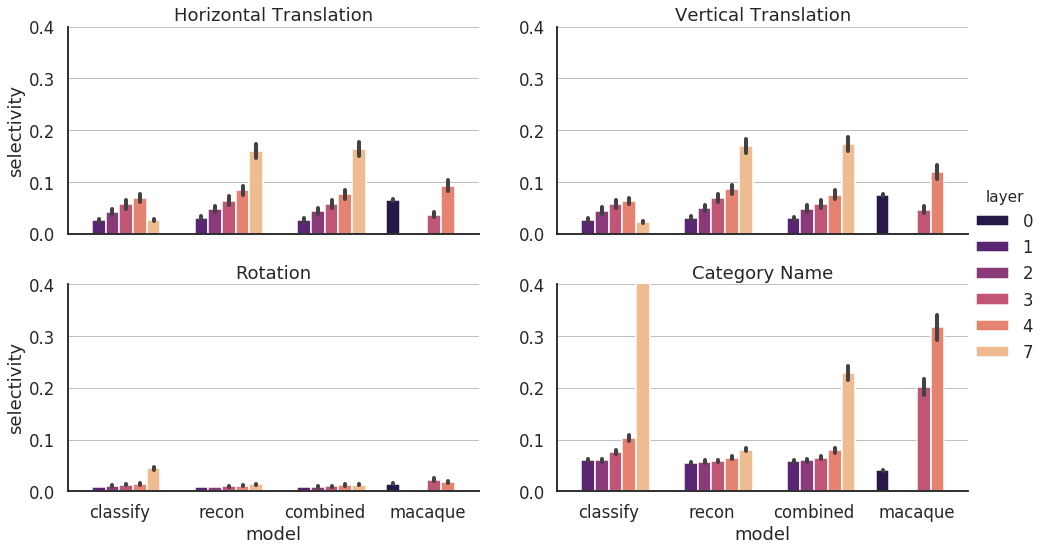

In [52]:
set_style()
sns.set_context('talk')
g = sns.catplot(x='model',y='selectivity',col='attribute', col_wrap=2,hue='layer',hue_order=[0,1,2,3,4,7], order=['classify', 'recon','combined','macaque'],
                kind='bar',data=dat,aspect=1.75,palette='magma',height=4,sharey=False,sharex=True,dodge=True)

g.set(ylim=(0, 0.4))
# g.axes[-1].set_ylim(0,1)

for ax,sub_title in zip(g.axes,['Horizontal Translation', 'Vertical Translation', 'Rotation', 'Category Name']):
    ax.get_yaxis().set_minor_locator(mpl.ticker.AutoMinorLocator())
    ax.grid(b=True, which='major', axis='y', color='gray', linewidth=0.5)

    ax.get_children()[-4].set_text(sub_title)
# g.fig
sns.despine(g.fig)
# mpl.pyplot.tight_layout()

In [51]:
g.savefig(os.path.join(proj_root,'figures','pub','neural_networks_revision','su_selectivity0.4max.png'),dpi=200)
g.savefig(os.path.join(proj_root,'figures','pub','neural_networks_revision','su_selectivity_0.4max.pdf'),dpi=200)

In [14]:
ax = g.axes[-1]

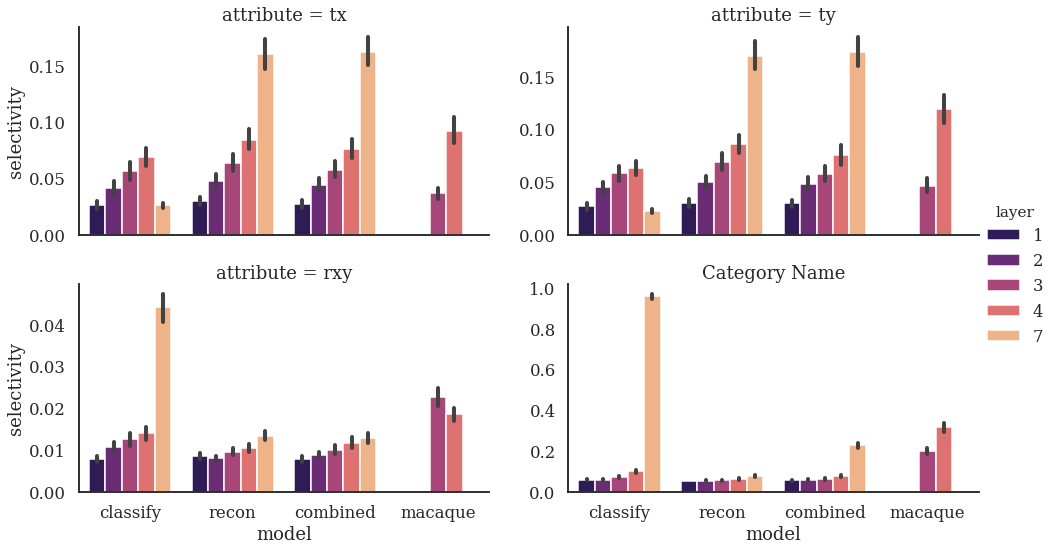

In [19]:
ax.figure

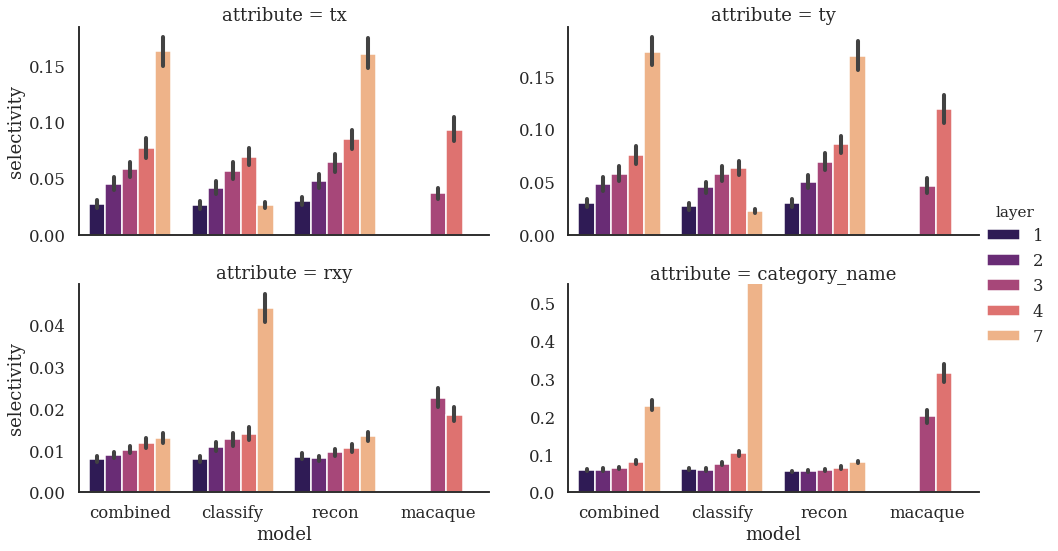

In [12]:
ax.set_ylim(0,0.55)
ax.figure